In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.execute
End_Date = session.query(func.max(Measurement.date)).all()
End_Date

[('2017-08-23')]

In [11]:
# Calculate the date 1 year agofrom the last data point in the database
end_date = '2017-08-23'
new_date = dt.datetime.strptime(end_date, '%Y-%m-%d')
new_date

datetime.datetime(2017, 8, 23, 0, 0)

In [12]:
# Perform a query to retrieve the data and precipitation scores
last_date_year = new_date - dt.timedelta(days=365)
last_date_year
start_date = last_date_year.strftime("%Y-%m-%d")
start_date

'2016-08-23'

In [13]:
dates = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>=start_date).\
    filter(Measurement.date<=end_date).\
    order_by(Measurement.date)


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
year_df = pd.DataFrame(dates)
# Sort the dataframe by date
year_df.rename(columns = {'date': 'Date', 'prcp': "Precipitation"}, inplace=True)
year_df.set_index('Date', inplace = True)
# Use Pandas Plotting with Matplotlib to plot the data
year_df.sort_values(by=['Date'])

Precipitation
Date                     
2016-08-23           0.00
2016-08-23           0.15
2016-08-23           0.05
2016-08-23            NaN
2016-08-23           0.02
...                   ...
2017-08-22           0.50
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.45

[2230 rows x 1 columns]

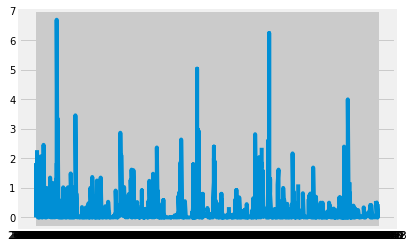

In [15]:
plt.plot(year_df)

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_df.describe()

Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
count = session.query(Station).count()
print(f"There are {count} stations")

There are 9 stations


In [18]:
print(f'Measurements tables')
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print()
print("stations tables")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

Measurements tables
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

stations tables
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
active = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).all()
# List the stations and the counts in descending order.
print(active)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == active[0][0])\
.order_by(Measurement.tobs).all()
# highest temperature recorded, and average temperature most active station?
temp

[(54.0, 85.0, 71.66378066378067)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1153e7978>]],
      dtype=object)

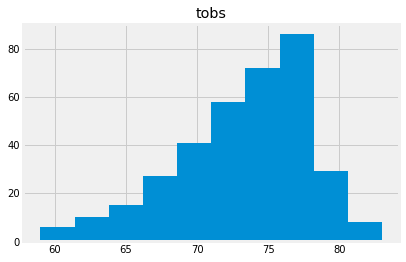

In [21]:
# Choose the station with the highest number of temperature observations.
last_twelve = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == active[0][0])\
.filter(Measurement.date >= start_date).all()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
pd1 = pd.DataFrame(last_twelve)
pd1.hist()

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps = (calc_temps(start_date, end_date))

tempMin = (calc_temps(start_date, end_date))[0][0]
tempAvg = (calc_temps(start_date, end_date))[0][1]
tempMax = (calc_temps(start_date, end_date))[0][2]

print(f"The min temp is {tempMin}, avg temp is {tempAvg}, and max temp is {tempMax} ")

The min temp is 58.0, avg temp is 74.59058295964125, and max temp is 87.0 


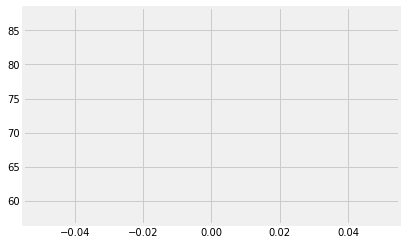

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.plot(temps)

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

